In [ ]:
# Alex Heater QLearning

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import pickle
from datetime import datetime, date, timedelta
from random import randint
from keras.models import load_model

import gym
from gym import Env, spaces

# from numba import jit

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
"""Custom Environment that follows gym interface"""
class CustomEnv(gym.Env):
    def __init__(self):
        super(CustomEnv, self).__init__()
                
        self.currentTime = '000030'
        self.initTemperature = 0
        self.currentTemperature = 0
        self.idealTemperature = 0
        N_DISCRETE_ACTIONS = 2 # 0= Off, 1=On
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.currentAction = 0
        self.roomTemp = 29
        self.highTemp = 100
        self.istraining = False
        
        # load models
        self.LR_model = pickle.load(open('linear_regression_nowaterusage.model', 'rb'))
        self.LR_s1 = pickle.load(open('linearregression_MinMaxScaler_nowaterusage.s1', 'rb'))
        self.LR_s2 = pickle.load(open('linearregression_MinMaxScaler_nowaterusage.s2', 'rb'))
        
        # penalties
        self.timePenalty = 0
        self.pricePenalty = 0
        self.comfortPenalty = 0

    def step(self, action):
        self.currentAction = action
        power = 1940 if action == 1 else 0.0
        curTemp = self.currentTemperature
        
        if(self.istraining):
            for i in range(10): # LR                
                transform = self.LR_s1.transform([[self.currentTime, power, self.currentTemperature]])
                predictedTemperature = self.LR_model.predict([[transform[0][0], transform[0][1], transform[0][2]]])        
                self.currentTemperature = np.round(self.LR_s2.inverse_transform([predictedTemperature])[0][0], 2)
        else: # LR
            transform = self.LR_s1.transform([[ power, self.currentTemperature]])
            predictedTemperature = self.LR_model.predict([[transform[0][0], transform[0][1] ]])
            self.currentTemperature = np.round(self.LR_s2.inverse_transform([predictedTemperature])[0][0], 2)
            
        newTemp = self.currentTemperature
        self.currentTemperature = curTemp        
        reward = self.calculateReward(newTemp)
        self.currentTemperature = newTemp
        
        # we will not drop water temperature below room temperature
        if(self.currentTemperature < self.roomTemp): self.currentTemperature = self.roomTemp
        # also, we will not increase water temp over highTemp = 100
        if(self.currentTemperature > self.highTemp): self.currentTemperature = self.highTemp
            
        self.currentTime = self.getnexttime()        
        return (self.currentTime, np.round(self.currentTemperature, 0), self.idealTemperature, 
                self.get_penalties()), reward, self.done(), []

    # re-initial the state of the environment
    def reset(self, istraining):
        self.istraining = istraining
        self.currentTemperature = randint(60, 75)
        self.currentTime = '000030'
        return (self.currentTime, np.round(self.currentTemperature, 0), self.idealTemperature, self.get_penalties())
    
    # adding one minute to the current time
    def getnexttime(self):
        newTime = datetime.strptime(str(date.today()) + ' ' + str(self.currentTime), '%Y-%m-%d %H%M%S') + timedelta(minutes=1)
        return newTime.strftime('%H%M%S')
    
    def done(self):        
        return True if(int(self.currentTime) > 235900
                      or self.currentTemperature < 5 or self.currentTemperature > 95) else False
    
    #calculate reward based on currentTemp and idealTemp
    def calculateReward(self, newTemp):
        idealTemp = self.idealTemperature - self.get_penalties()        
        if(newTemp < idealTemp):
            reward = newTemp - self.currentTemperature
            diff = abs(newTemp - idealTemp)
            coefficient = +1 if reward>0 else -1
            reward += coefficient * diff
        else:
            reward = self.currentTemperature - newTemp
            diff = abs(newTemp - idealTemp)
            coefficient = +1 if reward>0 else -1
            reward += coefficient * diff
        return round(reward, 1)
    
    # Render the environment to the screen
    def render(self, mode='human', close=False):        
        print(self.currentTime, " - ", self.idealTemperature, self.currentTemperature)
    
    # updating penalty parameters value
    def X_parameter(self, ideal_temp, time, price, comfort):
        self.idealTemperature = ideal_temp
        self.timePenalty = time
        self.pricePenalty = price
        self.comfortPenalty = comfort        
    
    # calculate penalty for the current state
    def get_penalties(self):
        if(int(self.currentTime) >= 220000 or int(self.currentTime) < 53000):
            tim = self.timePenalty[0]
        elif(int(self.currentTime) >= 53000 and int(self.currentTime) < 90000):
            tim = self.timePenalty[1]
        elif(int(self.currentTime) >= 90000 and int(self.currentTime) < 180000):
            tim = self.timePenalty[2]
        elif(int(self.currentTime) >= 180000 and int(self.currentTime) < 220000):
            tim = self.timePenalty[3]
        
        x_parameter = tim + self.pricePenalty + self.comfortPenalty
        return x_parameter

In [9]:
# To keep data
# q_table = {}

In [10]:
def Q_learning(q_table, episodes = 2000, gamma = 0.05, lr = 0.9, timestep = 100, epsilon = 0.1):
    rewards = 0
    steps = 0
    env = CustomEnv()
    result = []
    temp_lr = lr
    
    for ideal_temp in [70]:
        for time in [[0, 0, 0, 0], [45, 0, 45, 0]]:
            for price in [0, 5, 10]:
                for comfort in [0, 5]:
                    env.X_parameter(ideal_temp, time, price, comfort)
                    
                    lr = temp_lr
                    for episode in range(1,episodes+1):
                        if(episode % timestep == 0):
                            lr*= 0.99
        
                        current_state = env.reset(istraining=True)
                        done = False

                        while not done:
                            if(q_table.get(current_state, None) == None):
                                q_table[current_state] = [np.round(np.random.uniform(0, 1), 2),
                                                          np.round(np.random.uniform(0, 1), 2)]

                            if (np.random.uniform(0,1) < epsilon):
                                action = env.action_space.sample()
                            else:
                                action = np.argmax(q_table[current_state])

                            observation, reward, done, info = env.step(action)
                            next_state = observation

                            if not done:
                                if(q_table.get(next_state, None) == None):
                                    q_table[next_state] = [np.round(np.random.uniform(0, 1), 2), 
                                                           np.round(np.random.uniform(0, 1), 2)]

                                max_future_q = np.max(q_table[next_state])
                                current_q = q_table[current_state][action]
                                new_q = (1-lr)*current_q + lr*(reward) + gamma*max_future_q
                                q_table[current_state][action] = round(new_q, 1)
                                current_state = next_state
                            else:
                                q_table[current_state][action] = round(reward, 1)
                                break

In [17]:
result = Q_learning(q_table, episodes=4000, gamma=0.05, lr=0.9, timestep=400, epsilon=0.1)

x_parameter:,  70 [0, 0, 0, 0] 0 0
x_parameter:,  70 [0, 0, 0, 0] 0 5
x_parameter:,  70 [0, 0, 0, 0] 5 0
x_parameter:,  70 [0, 0, 0, 0] 5 5
x_parameter:,  70 [0, 0, 0, 0] 10 0
x_parameter:,  70 [0, 0, 0, 0] 10 5


In [38]:
# for k, v in q_table.items():
#     print(k[0], k[1], np.argmax(v))

In [11]:
# pickle.dump(q_table, open('Q_Table.dump', 'wb'))
q_table = pickle.load(open('Q_Table.dump', 'rb'))

In [12]:
env = CustomEnv()

#pre-set parameters
ideal_temp = 70
time = [0, 0, 0, 0]
price = last_price_penalty = 0 # 10
comfort = 0 # 5
env.X_parameter(ideal_temp, time, price, comfort)

#loading power price
file = '''daily_power_price.csv'''
power_price = pd.read_csv(file)
power_price.index = power_price.time

def get_price_penalty(time):    
    price = power_price[power_price.index == time].price.values[0]    
    if(price>0 and price<100): return 0
    if(price>100 and price<200): return 5
    if(price>200): return 10
    
result = []
current_state = env.reset(istraining=False)
done = False

while not done:    
    currhour = int(current_state[0][0:2])
    new_price_penalty = get_price_penalty(currhour)
    
    if(new_price_penalty != last_price_penalty):
        print_penalty = current_state[3]
        print_penalty -= last_price_penalty
        print_penalty += new_price_penalty
        last_price_penalty = new_price_penalty
        current_state = (current_state[0],current_state[1],current_state[2],print_penalty)
        env.X_parameter(ideal_temp, time, new_price_penalty, comfort)        
    
    if(q_table.get(current_state, None) == None):
#         print('None')
        q_table[current_state] = [np.round(np.random.uniform(0, 1), 2), np.round(np.random.uniform(0, 1), 2)]    
    action = np.argmax(q_table[current_state])
    result.append([current_state, 0 if action == 0 else 1940])
    
    observation, reward, done, info = env.step(action)
#     print(observation, action, reward)
    current_state = observation

    if done:
        break

In [14]:
temps = [item[0][1] for item in result]
penalty = [item[0][3] for item in result]
actions = [item[1] for item in result]
xtim = [i/60 for i in range(len(result))]

In [15]:
# Raw data of one particular day
file = '''RPT1106_data_1440.csv'''
newdata = pd.read_csv(file)
x = [i/60 for i in range(1440)]

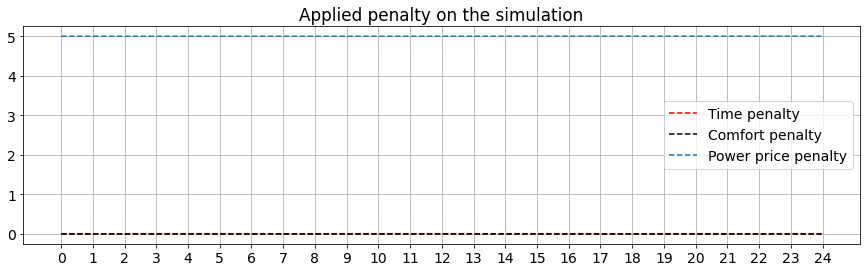

In [21]:
timepenalty  = [time[0] for i in range(330)]
[timepenalty.append(time[1]) for i in range(210)]
[timepenalty.append(time[2]) for i in range(9*60)]
[timepenalty.append(time[3]) for i in range(6*60)]

comfortpenalty  = [comfort for i in range(len(penalty))]
penalty = [penalty[i] - (timepenalty[i] + comfort) for i in range(len(penalty))]

plt.rcParams["figure.figsize"] = (15, 4)
plt.plot(x, timepenalty, 'r--', label='Time penalty')
plt.plot(x[:1439], comfortpenalty, 'k--', label='Comfort penalty')
plt.plot(x[:1439], penalty, '--', label='Power price penalty')
plt.xticks(np.arange(0, 25, 1))
plt.title('Applied penalty on the simulation')
plt.grid()
plt.legend()

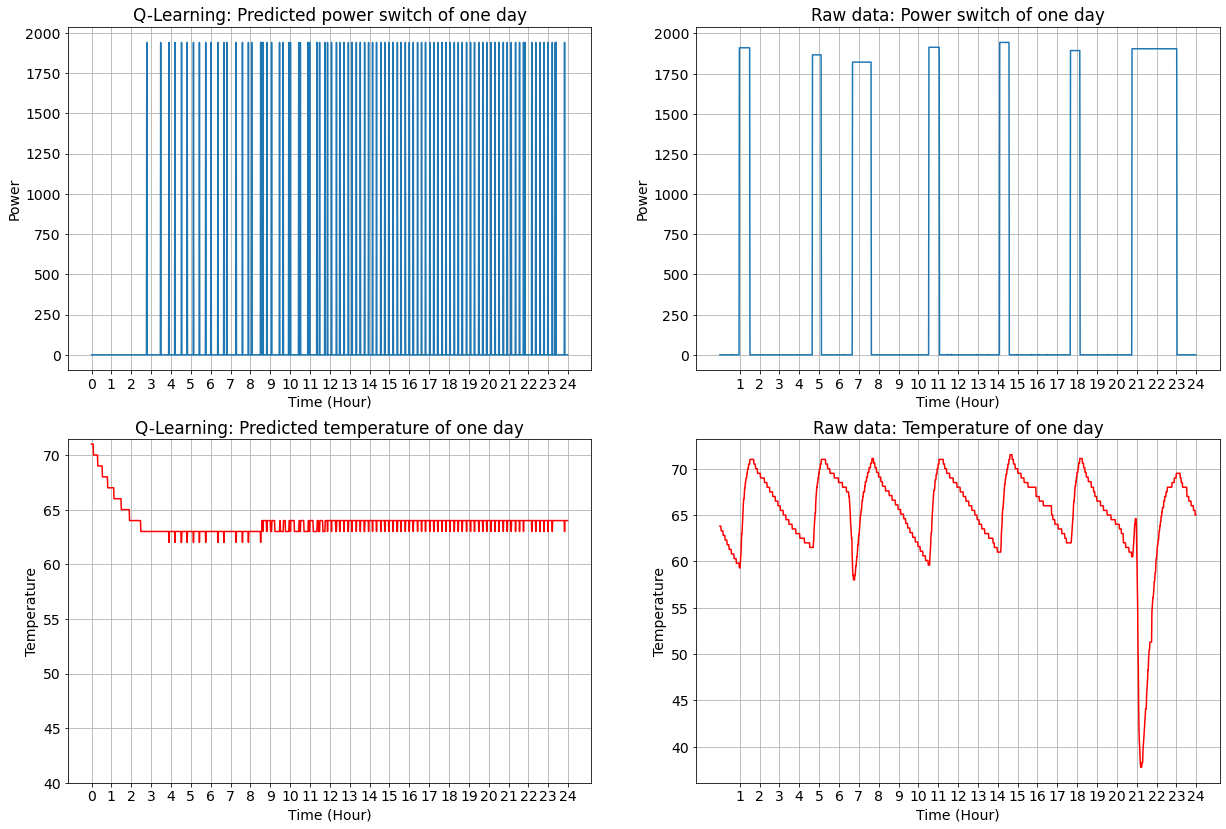

<Figure size 432x288 with 0 Axes>

In [17]:
plt.rcParams.update({'font.size': 14})
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, gridspec_kw=dict(left=0.1, right=0.9,
                                        bottom=0.1, top=2.2), figsize=(20, 5))

ax1.plot(xtim, actions, '-', label="Power switch")
ax1.set_xticks(np.arange(0, 25, 1))
ax1.set_xlabel('Time (Hour)')
ax1.set_ylabel('Power')
ax1.set_title("Q-Learning: Predicted power switch of one day")
ax1.grid()

ax3.plot(xtim, temps, 'r-', label="Temperature")
ax3.set_xticks(np.arange(0, 25, 1))
ax3.set_yticks(np.arange(40, 75, 5))
ax3.set_xlabel('Time (Hour)')
ax3.set_ylabel('Temperature')
ax3.set_title("Q-Learning: Predicted temperature of one day")
ax3.grid()

ax2.set_title("Raw data: Power switch of one day")
ax2.plot(x, newdata.power[0:1440], '-', label='Power')
ax2.set_xticks(np.arange(1, 25, 1))
ax2.set_ylabel('Power')
ax2.set_xlabel('Time (Hour)')
ax2.grid()

ax4.plot(x, newdata.temperature[0:1440], 'r-', label='Temperature')
ax4.set_xticks(np.arange(1, 25, 1))
ax4.set_title("Raw data: Temperature of one day")
ax4.set_xlabel('Time (Hour)')
ax4.set_ylabel('Temperature')
ax4.grid()

plt.show()
plt.savefig('Predict_power_usage.png')

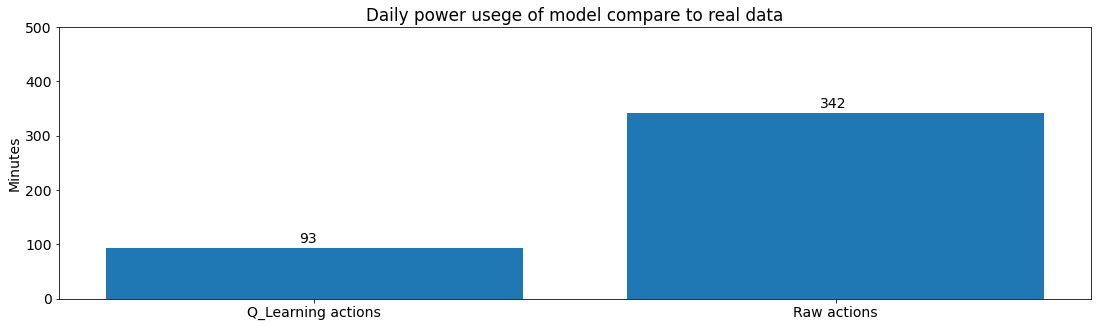

In [18]:
pre_action = sum([1 if item>0 else 0 for item in actions[0:1440]])
raw_action = sum([0 if item<250 else 1 for item in newdata.power[0:1440]])

plt.rcParams["figure.figsize"] = (18.5, 5)
plt.title('Daily power usege of model compare to real data')
z=['Q_Learning actions', 'Raw actions']
y=[pre_action, raw_action]
plt.bar(z, y)
plt.yticks(np.arange(0, 501, 100))
plt.ylabel('Minutes')

for i, v in enumerate(z):
    plt.text(i-0.03, y[i]+10 , y[i])
    
plt.savefig('Daily_power_usege.png')
plt.show()